<h2 align="center">Monte Carlo</h2> 

Sometimes physical systems consist of many parameters that are not well known, or that evolve over time in unpredictable ways.  Magnetic spins, diffuse light scattering, and electron gases are all examples of systems that can better be modeled using Monte Carlo methods, so named because the randomness involved <a href="https://en.wikipedia.org/wiki/Monte_Carlo_method#History">reminded Nicholas Metropolis</a> of gambling at the famous casino in Monte Carlo, in Monaco. (Metropolis and his colleagues were working at Los Alamos shortly after the end of World War II, and modeling neutron transport through materials.) 

In lab today we will explore these methods by modeling how light scatters through biological tissue. As you might imagine, understanding this is important for understanding different kinds of medical imaging.  Light scattering is a natural use of Monte Carlo methods, because in many cases, when an atom or molecule absorbs a photon, a short time later it re-emits a photon in a random direction, retaining no memory of the initial direction of the photon.  We can model this behavior by generating random numbers and using them to specify the direction and distance that the photon travels.  In some cases, there *is* some memory of the photon's initial direction (e.g. it is more likely to scatter forward than backward).  As we will see, we can also model such cases by specifying a non-uniform distribution (with whatever functional form suits the particular situation) for the new direction; this is called the *phase function* of the scattering. 

## Random numbers

Some physical processes are random (e.g. radioactive decay), and early calculations with Monte Carlo simulations used tables of these truly random numbers.  However, using tabulated random numbers is tedious, and it's useful if we can generate new ones with a computer. 

However, nothing a computer does is truly random, so these are more technically termed "pseudo-random" numbers.  For most purposes these are plenty random enough for anything we want to do, but if your analysis depends heavily on them, it is good to be aware of the strength (i.e. randomness) of the random number generator in the language you're using.  In particular, some algorithms will always give you the same pseudo-random sequence unless you are careful to alter the "seed" given to the algorithm.  (This isn't a problem with the Python routines we'll be using today.) 

#### Exercise 1
To explore Python's random number generation, use `numpy.random.random()` to generate 1000 `x` values and 1000 `y` values.  (As with other specific routines we'll mention here, you can find the documentation for this routine with a little web searching, to understand what it expects as inputs and what it returns.)  With these values:

* Plot them in a labeled x-y plot (as points, not lines!).  They should look randomly distributed. 
* Plot a histogram of their values (using `hist`).

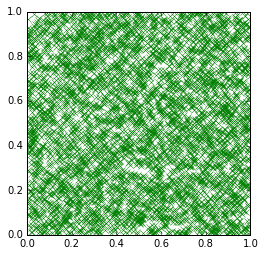

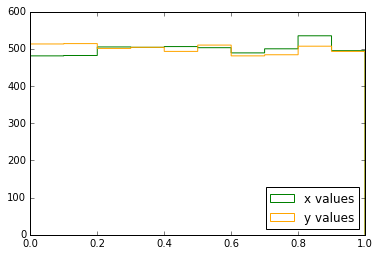

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n = 5000
x = np.random.random(n)
y = np.random.random(n)

plt.plot(x,y,'gx')
# Force aspect ratio to be equal:
plt.axes().set_aspect('equal')
plt.show()
plt.hist(x, label="x values", color="green", histtype="step")
plt.hist(y, label="y values", color="orange", histtype="step")
plt.legend(loc='lower right')
plt.show()

#### Exercise 2

Using your `x` and `y` values from above, do a simple approximation of $\pi$, as follows.  Select only those points that lie at a distance less than or equal to 1 away from the origin, i.e. that lie in the first quadrant of the unit circle.  With a little thought, you should be able to figure out how to use the number of values you find to make a calculation of the value of $\pi$. 

Here's a little hint about a `numpy` feature that will be useful here, and below.  Rather than looping over a numpy array one element at a time to find elements with certain values, you can do the following:

In [2]:
# This lets the code work in Python 2 or 3:
from __future__ import division, print_function

# Make a list of integers for our example:
values = np.arange(10)

# Assign a new variable to the output of a logical test:
less_than_five = (values < 5)

# Note that this produces an array of boolean values:
print("Contents of array 'less_than_five':")
print(less_than_five)

# Now we can use this boolean array as an *index*, to 
# pull out only the desired elements:
new_values = values[less_than_five]
print()  # Just a blank line.
print("Result of array 'values' indexed by 'less_than_five' array:")
print(new_values)

Contents of array 'less_than_five':
[ True  True  True  True  True False False False False False]

Result of array 'values' indexed by 'less_than_five' array:
[0 1 2 3 4]


OK, now do the above exercise for simulating $\pi$, using the indexing trick just outlined.  If your value for $\pi$ is relatively inaccurate, increase the number of random values you use until you reliably get it correct to at least two or three decimal places.  Don't worry - you'll find that generating even millions of random numbers is relatively quick.

In [3]:
n = int(1E7)
x = np.random.random(n)
y = np.random.random(n)

# Calculate distance from the origin:
r = np.sqrt(x**2 + y**2)
# Which ones are within one unit:
in_the_circle = (r <= 1)
# Calculate pi from the ratio of those in, to the
# total number.  This is 1/4 of a circle, so should
# have area of pi/4.  Multiply by 4 to get our pi
# estimate:
my_pi = 4. * len(r[in_the_circle])/len(r)
print("Estimate of pi is", my_pi)

Estimate of pi is 3.1420984


## Applications to light scattering

OK, now let's do something more interesting than calculating $\pi$!  We'll take an example of a light source (e.g. a laser) being shone through some tissue.  If there were no scattering or absorption, the image of the light coming out would be the same as it was going in, i.e. a relatively compact point source.  ("No scattering or absorption" is another way of saying "transparent", so just think of shining a light through a pane of glass.)  However, if there *is* some scattering, the image will change. (Think about the same example, but with a frosted pane of glass rather than a clear one.)  Being able to model how the image changes as it passes through tissue helps diagnosticians understand what the tissue properties are, since, e.g., a tumor might have different light scattering or absorption properties than healthy tissue. 

Read the first four pages of the PDF posted in Moodle.  We will be following the mathematical framework spelled out there to model light scattering through a slab of tissue.  You can stop when you get to the part labeled "Lab Assignment".  We'll be doing exercises similar to those, but breaking it down a bit more into steps.  

#### Exercise 3

Look at equation 1 in the background document, and use it generate a `numpy` array of step sizes.  Write it as a function that takes as input the number of steps $n$, and the desired mean step size, and returns a `numpy` array of steps.  Hint: `np.log` gives the natural logarithm, as desired in this equation; the base-10 log is written `np.log10`.  

After writing your function, write code to call your function to generate 1000 steps with a mean step size of 0.01 (a typical mean free path for a visible-light photon in tissue), and plot a histogram of the step values. 

Mean step size is 0.01


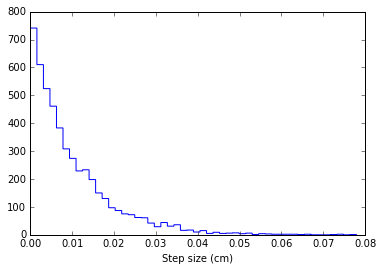

In [4]:
import numpy as np
def calc_steps(n, mean_step_size):
    '''Calculate an array of steps, with an exponential
    distribution and mean step size.  Inputs: number
    of steps n, and mean step size mean_step_size. 
    Returns: numpy array of steps.'''
    
    # Initial array of uniform randoms, and take
    # natural log to get exponential distribution:
    steps = np.log(np.random.random(n))
    # Calculate mean and adjust to get desired 
    # mean:
    steps = steps * mean_step_size / np.average(steps)
    return steps

steps = calc_steps(5000, 0.01)
print("Mean step size is", np.average(steps))
plt.hist(steps, bins=50, histtype='step')
plt.xlabel("Step size (cm)")
plt.show()

#### Exercise 4

Implement equations 5 and 6 as two functions, to return values of $\theta$ and $\phi$.  Your function for $\theta$ should take as inputs the value of $g$, the anisotropy parameter, and $n$, the number of steps desired, and return an $n$-element `numpy` array of $\theta$ values.  Alternatively, it's fine for your function to return $\cos \theta$ rather than $\theta$ - in fact that's more efficient, since you need $\cos \theta$ in equations 7-9 anyway.  Just be sure to keep track of which one you have!  Also write a separate function that returns $n$ values of $\phi$.  (Note that it's fine for $n$ to be 1; a `numpy` array of length 1 can be treated as a scalar in your code with no problems, i.e. any `numpy` operations work fine on scalars as well as vectors.)

After writing your function, test it by plotting histograms of the $\theta$ and $\phi$ values generated.  For $\theta$, plot both the $g=0$ and $g=0.9$ cases.

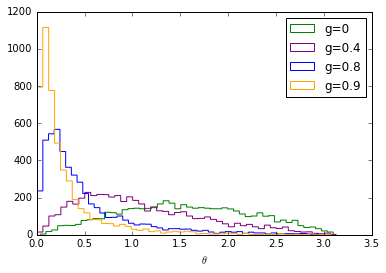

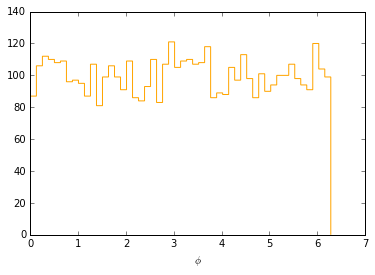

In [5]:
def calc_cos_theta(g, n=1):
    '''Calculate a value of cos theta using equation 5.
    Default to only one value, but calculate n if specified.
    Returns numpy array of cos theta values.'''
    
    rands = np.random.random(n)
    if g==0:
        return 2.0*rands - 1
    else:
        cos_theta = (1./(2.*g))*(1 + g**2 - ((1-g**2)/(1-g+2*g*rands))**2)
        return cos_theta

def calc_phi(n=1):
    '''Calculate a value of phi using equation 6.
    Default to only one value, but calculate n if specified.
    Returns numpy array of phi values.'''
    return 2 * np.pi * np.random.random(n)

# Test by plotting some histograms.  For theta, we'll convert from 
# cos theta into theta itself:
n = 5000
theta = np.arccos(calc_cos_theta(g=0,n=n))
plt.hist(theta, 50, label='g=0', color='green', histtype='step')
theta = np.arccos(calc_cos_theta(g=0.4,n=n))
plt.hist(theta, 50, label='g=0.4', color='purple', histtype='step')
theta = np.arccos(calc_cos_theta(g=0.8,n=n))
plt.hist(theta, 50, label='g=0.8', color='blue',histtype='step')
theta = np.arccos(calc_cos_theta(g=0.9,n=n))
plt.hist(theta, 50, label='g=0.9', color='orange',histtype='step')
plt.legend()
plt.xlabel('$\\theta$')
plt.show()
                  
phi = calc_phi(n)
plt.hist(phi, 50, color='orange',histtype='step')
plt.xlabel('$\phi$')
plt.show()

#### Exercise 5

As the final piece of the puzzle before doing the actual scattering calculation, write a function that implements equations 7-9 (as well as checking for the special case of equations 10-12) to calculate the new direction cosines based on the old ones, given the new scattering angles.  To get a function to return three values (your three direction cosines), you just give the function's `return` statement three values, e.g. 

`return mu_x, mu_y, mu_z`

You can capture these outputs into separate variables when calling the function if you assign the function's output to three variables on the calling end, e.g. 

`a, b, c = myfunc(x)`

After writing your functions, show that they return the expected values for $\theta = 0, \phi = 0$; for $\theta = \pi/2, \phi = 0$; and that both of those cases work when $\mu_z = 1$ and when $\mu_z$ is not close to 1.  

In [6]:
def calc_mus(cos_theta, phi, mu_x, mu_y, mu_z):
    '''Calculate new direction cosines, given the old ones
    as inputs, and new scattering angles cos theta, and phi.
    Returns three-element list of new values of mu_x, mu_y,
    and mu_z.'''
    
    # Calculate sin_theta from cos_theta:
    sin_theta = np.sqrt(1 - cos_theta**2)
    
    # Also need cos(phi) and sin(phi). We use them 
    # repeatedly so a little faster to calculate them
    # up front:
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    
    # Have to consider two different cases, depending on value
    # of mu_z:
    if abs(mu_z) > 0.999:
        mu_x_prime = sin_theta * cos_phi
        mu_y_prime = sin_theta * sin_phi
        mu_z_prime = (abs(mu_z)/mu_z)*cos_theta        
    else:
        mu_x_prime = sin_theta * (mu_x*mu_z*cos_phi - mu_y*sin_phi)/np.sqrt(1-mu_z**2) + mu_x*cos_theta
        mu_y_prime = sin_theta * (mu_y*mu_z*cos_phi + mu_x*sin_phi)/np.sqrt(1-mu_z**2) + mu_y*cos_theta
        mu_z_prime = -sin_theta * cos_phi * np.sqrt(1-mu_z**2) + mu_z*cos_theta
    return mu_x_prime, mu_y_prime, mu_z_prime

# First test with all initial mu values set to 0.5:
mu_x = 1/np.sqrt(2)
mu_y = 1/np.sqrt(2)
mu_z = 0
theta = 0
phi = 0
new_mu_x, new_mu_y, new_mu_z = calc_mus(np.cos(theta), phi, mu_x, mu_y, mu_z)
print("Input mu values are:")
print(mu_x, mu_y, mu_z)
print("New mu values for theta=%0.1f, phi=%0.1f are:" % (theta, phi))
print(new_mu_x, new_mu_y, new_mu_z)
print()

theta = np.pi/2.
phi = 0
new_mu_x, new_mu_y, new_mu_z = calc_mus(np.cos(theta), phi, mu_x, mu_y, mu_z)
print("Input mu values are:")
print(mu_x, mu_y, mu_z)
print("New mu values for theta=%0.1f, phi=%0.1f are:" % (theta, phi))
print(new_mu_x, new_mu_y, new_mu_z)
print()

# First test with all initial mu values set to 0.5:
mu_x = 0.
mu_y = 0.
mu_z = 1
theta = 0
phi = 0
new_mu_x, new_mu_y, new_mu_z = calc_mus(np.cos(theta), phi, mu_x, mu_y, mu_z)
print("Input mu values are:")
print(mu_x, mu_y, mu_z)
print("New mu values for theta=%0.1f, phi=%0.1f are:" % (theta, phi))
print(new_mu_x, new_mu_y, new_mu_z)
print()

theta = np.pi/2.
phi = 0
new_mu_x, new_mu_y, new_mu_z = calc_mus(np.cos(theta), phi, mu_x, mu_y, mu_z)
print("Input mu values are:")
print(mu_x, mu_y, mu_z)
print("New mu values for theta=%0.1f, phi=%0.1f are:" % (theta, phi))
print(new_mu_x, new_mu_y, new_mu_z)
print()



Input mu values are:
0.707106781187 0.707106781187 0
New mu values for theta=0.0, phi=0.0 are:
0.707106781187 0.707106781187 0.0

Input mu values are:
0.707106781187 0.707106781187 0
New mu values for theta=1.6, phi=0.0 are:
4.32978028118e-17 4.32978028118e-17 -1.0

Input mu values are:
0.0 0.0 1
New mu values for theta=0.0, phi=0.0 are:
0.0 0.0 1.0

Input mu values are:
0.0 0.0 1
New mu values for theta=1.6, phi=0.0 are:
1.0 0.0 6.12323399574e-17



#### Exercise 6

Now we're ready to actually track some photons!  Write code that tracks $n$ photons through a tissue sample that is 1 cm thick.  Follow the flowchart in Figure 1 and the explanation there to step a photon through the sample; for each photon, you'll need to follow it until it exits the sample.  (We'll assume that the sample is infinitely large in $x$ and $y$, and has finite thickness only in the $z$ direction.)  When each photon exits the sample, store its $x$ and $y$ position in lists; we'll use these to create an image of what the output light beam looks like when it exits the tissue. 

After you have run all $n$ photons and stored their final positions, make an $x-y$ plot.  You can make a simple plot with just `mp.plot(x, y, 'g.')`.

Start by running just a small number of photons (100 or so), and experiment with different values of $g$.  When you have code that is working well, you can gradually increase the number of photons to get better-looking images.  How many you use will depend on how fast your code is, and how patient you are!  Display at least two final images, for $g=0.1$ and $g=0.9$.  Comment on why they look the way they do.  That is, explain why you would expect different values of $g$ to influence the images in the way that is shown.

Note that when you have a lot of photons, they start to overlap in the plot and it can be harder to tell how concentrated they are.  Some examples of other ways to visualize the data are below.

In [7]:
def scatter(n_photons, g, step_size, z_max=0.1, x_max=1, y_max=1, plot=True):
    '''Function to do Monte Carlo light scattering using the above formalism.
    Takes inputs of number of photons to run, asymmetry parameter g, 
    mean step size (cm), and optionally the slab dimensions in the x, y,
    and z dimensions (all in cm).  Photons start at z=0 and are tracked if
    they emerge at z_max; if they exceed +/-x_max or +/-y_max they are lost
    and not tracked further.  Returns two numpy arrays, the final x and y positions 
    of those photons that make it through.  Optionally plot the results.'''
    
    # Time this chunk:
    import time
    start = time.time()

    # print status for each photon?
    do_print = False

    # Initialize lists for final positions:
    final_x = []
    final_y = []

    # Now loop over all photons:
    for i in range(n_photons):
        # Set up initial conditions:
        x = 0
        y = 0
        z = 0

        # Initial directions:
        mu_x = 0
        mu_y = 0
        mu_z = 1

        # Step length for this first step:
        s = np.asscalar(calc_steps(1,step_size))

        # Advance by this step size
        x += s*mu_x
        y += s*mu_y
        z += s*mu_z

        # Since array ops are so much faster, generate 
        # a bunch of the numbers we'll need to go to 
        # repeatedly, all at once:
        k = 10000
        s_list = calc_steps(k, step_size)
        theta_list = calc_cos_theta(g, k)
        phi_list = calc_phi(k)

        # Now keep doing steps until we 
        # exit the sample:
        j = 0
        while z < z_max:
            # Step length for this step:
            s = s_list[j]

            # Get new directions from old:
            mu_x, mu_y, mu_z = calc_mus(theta_list[j], phi_list[j], mu_x, mu_y, mu_z)

            # Advance by this step size
            x += s*mu_x
            y += s*mu_y
            z += s*mu_z

            if (abs(x) > x_max or abs(y) > y_max):
                break

            j += 1
            if j >= k:
                # Need some new random variables:
                if do_print:
                    print("Needed new random vars for photon %d." % i)
                s_list = calc_steps(k, step_size)
                theta_list = calc_cos_theta(g, k)
                phi_list = calc_phi(k)
                j = 0


        # When we've exited the while loop, we should be out
        # of the slab; save the x and y positions:
        if (abs(x) > x_max or abs(y) > y_max):
            if do_print:
                print("Did photon %d, lost from slab at %f, %f, took %d steps." % (i, x, y, j))
        else:
            final_x.append(x)
            final_y.append(y)
            if do_print:
                print("Did photon %d, ended at %f, %f, took %d steps." % (i, x, y, j))

    # All photons done - plot if desired.
    if plot:
        plt.plot(final_x, final_y, 'g.', label="g=%0.1f" % g)
        plt.xlabel("Position (cm)")
        plt.ylabel("Position (cm)")
        plt.xlim([-1,1])
        plt.ylim([-1,1])
        plt.axes().set_aspect('equal')
        plt.legend()
        plt.show()

    elapsed = time.time() - start

    print("Took %d seconds for %d photons." % (elapsed, n_photons))
    return np.array(final_x), np.array(final_y)

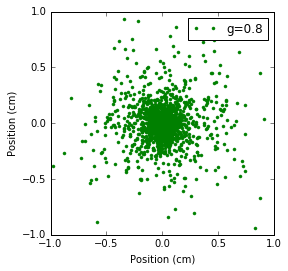

Took 7 seconds for 2000 photons.


In [8]:
# Quick test with a modest number of photons:
n_photons = 2000
g = 0.8
step_size = 0.01
x, y = scatter(n_photons, g, step_size)

In [11]:
# Now do more photons to test what different values of 
# g look like in a systematic way:

import seaborn as sns
import matplotlib

n_photons = 15000
g_list = [0.1, 0.3, 0.5, 0.7, 0.9]
step_size = 0.01

xlist = []
ylist = []

sns.set_palette(sns.color_palette("Set1", 10))

for g in g_list:
    # Do the scattering calc and save positions:
    x, y = scatter(n_photons, g, step_size, plot=False)
    xlist.append(x)
    ylist.append(y)


Took 256 seconds for 15000 photons.
Took 481 seconds for 15000 photons.
Took 150 seconds for 15000 photons.
Took 88 seconds for 15000 photons.
Took 33 seconds for 15000 photons.


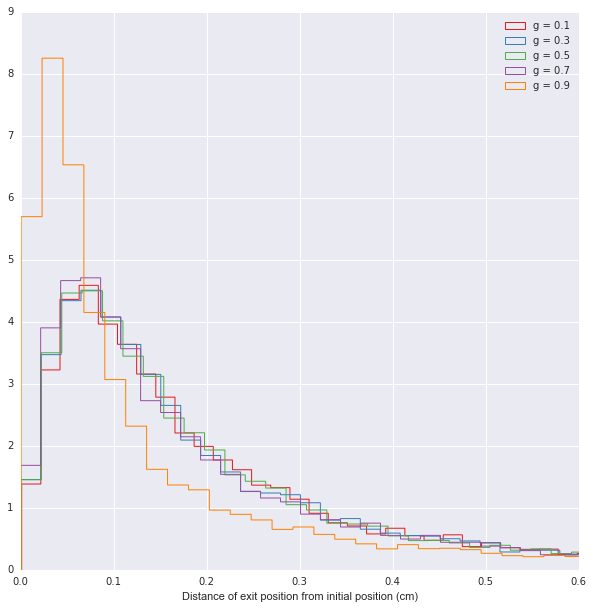

In [12]:
# Plot the results from the runs saved above:
matplotlib.rcParams['figure.figsize'] = 10, 10

for x, y, g in zip(xlist, ylist, g_list):
    r = np.sqrt(x**2 + y**2)
    plt.hist(r, 60, label='g = %0.1f' % g, \
             histtype='step', linewidth=1, normed=True)

plt.xlim([0,0.6])
plt.legend()
plt.xlabel('Distance of exit position from initial position (cm)')
plt.savefig('light_scattering_r_vs_g.png')
plt.show()

In [13]:
n_photons = 15000
g_list2 = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
step_size = 0.01

xlist2 = []
ylist2 = []

for g in g_list2:
    # Do the scattering calc and save positions:
    x, y = scatter(n_photons, g, step_size, plot=False)
    xlist2.append(x)
    ylist2.append(y)


Took 89 seconds for 15000 photons.
Took 79 seconds for 15000 photons.
Took 61 seconds for 15000 photons.
Took 47 seconds for 15000 photons.
Took 33 seconds for 15000 photons.
Took 20 seconds for 15000 photons.


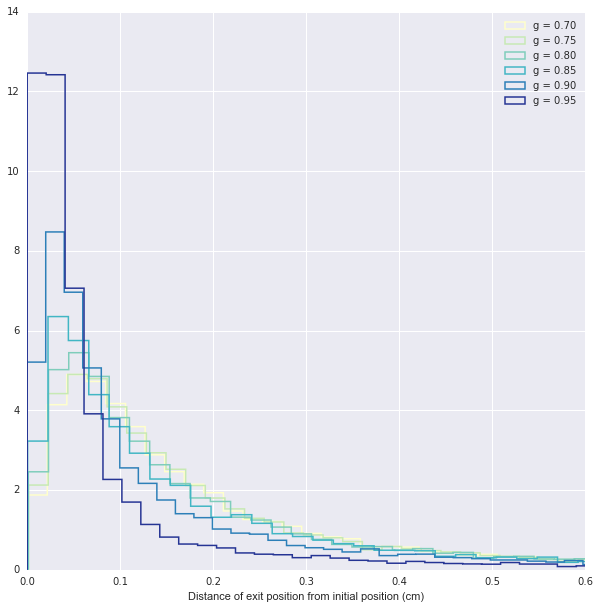

In [15]:
# Plot the results from the runs saved above:
matplotlib.rcParams['figure.figsize'] = 10, 10

# Color palette from Color Brewer
sns.set_palette(sns.color_palette(['#ffffcc','#c7e9b4', \
                                   '#7fcdbb','#41b6c4', \
                                   '#2c7fb8','#253494']))

for x, y, g in zip(xlist2, ylist2, g_list2):
    r = np.sqrt(x**2 + y**2)
    plt.hist(r, 60, label='g = %0.2f' % g, \
             histtype='step', linewidth=1.5, normed=True)

plt.xlim([0,0.6])
plt.legend()
plt.xlabel('Distance of exit position from initial position (cm)')
plt.savefig('light_scattering_r_vs_g_2.png')
plt.show()

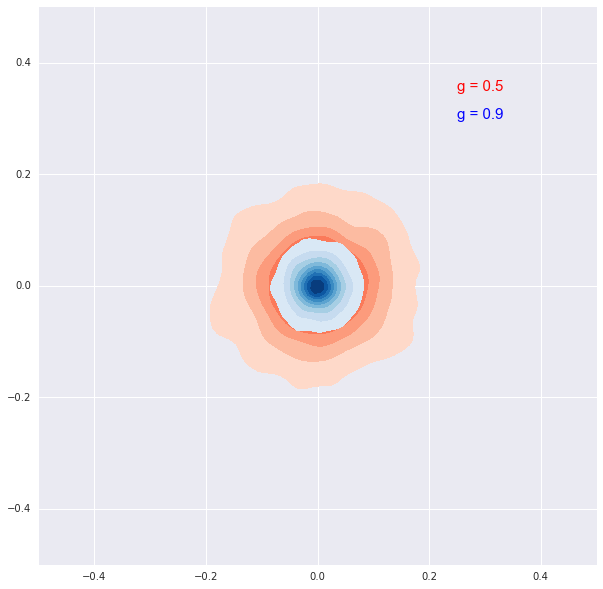

In [17]:
# Finally, here's a way to plot something that looks more like an image;
# We'll plot maps of two different g values on top of each other, in different colors.

i = 2
ax = sns.kdeplot(xlist[i], ylist[i], \
                 shade=True, cmap='Reds', \
                 clip=([-0.5,0.5],[-0.5,0.5]), shade_lowest=False)
ax.set_aspect('equal')
ax.text(0.25, 0.35, "g = %0.1f" % g_list[i], color="red", fontsize=15)
i = 4
sns.kdeplot(xlist[i], ylist[i], \
            shade=True, cmap='Blues', ax=ax, shade_lowest=False,\
            clip=([-0.5,0.5],[-0.5,0.5]))
ax.text(0.25, 0.3, "g = %0.1f" % g_list[i], color="blue", fontsize=15)
plt.show()
